In [1]:
import math
import time
import matplotlib.pyplot as plt
import torch
import trimesh

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 1024
config.raster_radius = 0.012
config.raster_points_per_pixel = 4
    
d_size = 514
config.data_blueprint = f'blueprint_radial_{d_size}.npz'
config.data_blueprint_size = d_size
config.data_patch_size = d_size
config.raster_max_brightness = 0.9
blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 264196, 3]),
 torch.Size([1, 264196, 3]),
 torch.Size([1, 526338, 3]))

In [3]:
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

0.6632351875305176


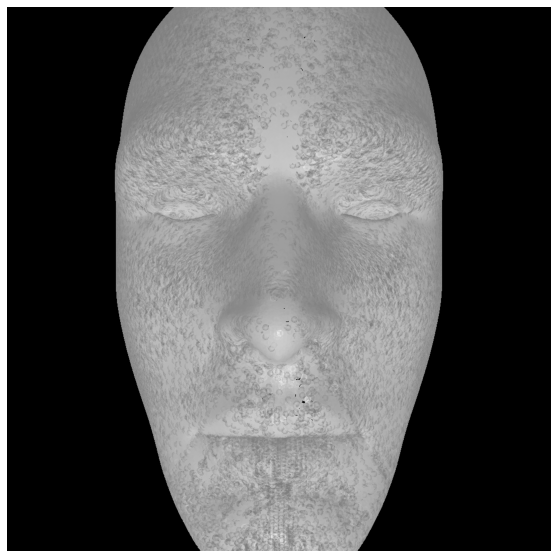

In [4]:
cal_normals = R.vrt_nrm.vertex_normals_fast(points)
cal_normals
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [5]:
cal_normals.shape, normals.shape

(torch.Size([1, 264196, 3]), torch.Size([1, 264196, 3]))

In [6]:
dot =(cal_normals * normals).sum(dim=-1)
dot.sum() / dot.numel()

tensor(0.2699, device='cuda:0')

0.2417607307434082


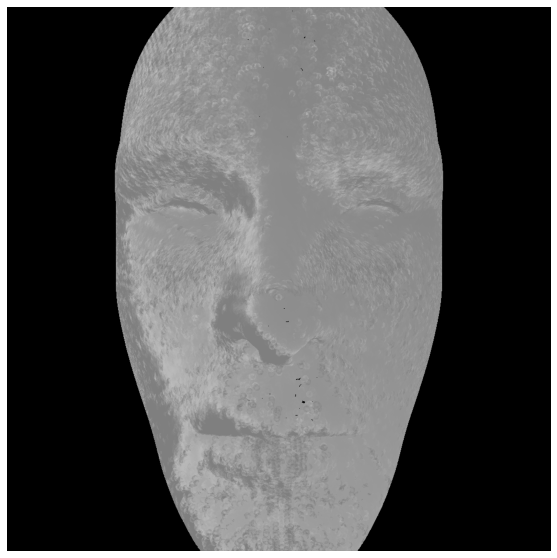

In [7]:
from src.util import gaussian_conv2d

conv = gaussian_conv2d(3, 1).to(device)

cal_normals = R.vrt_nrm.vertex_normals_fast(points)
cal_normals = cal_normals.reshape(1, d_size, d_size, 3).permute(0, 3, 1, 2)
cal_normals = F.normalize(conv(cal_normals), dim=-1)
cal_normals = grid_to_list(cal_normals)
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off")
plt.axis("off");

0.22219562530517578


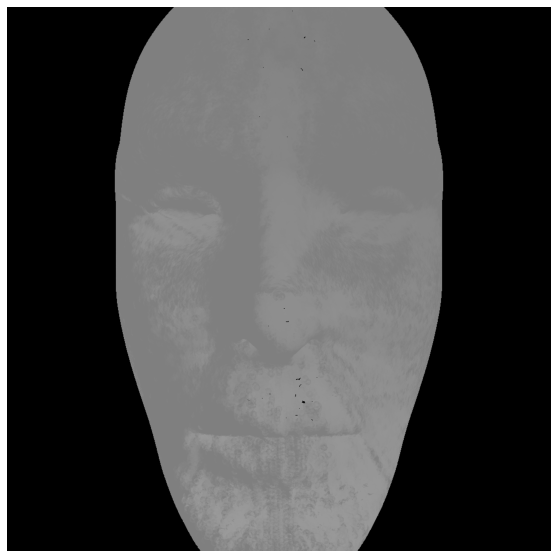

In [9]:
conv = gaussian_conv2d(5, 1, padding=2).to(device)

cal_normals = R.vrt_nrm.vertex_normals_fast(points)
cal_normals = cal_normals.reshape(1, d_size, d_size, 3).permute(0, 3, 1, 2)
cal_normals = F.normalize(conv(cal_normals), dim=-1)
cal_normals = grid_to_list(cal_normals)
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off")
plt.axis("off");